# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Simple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
import warnings
warnings.simplefilter("ignore")

In [5]:
from backtesting import Strategy

## Getting the Data

In [6]:
XAUUSD = load_data()

In [7]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [8]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


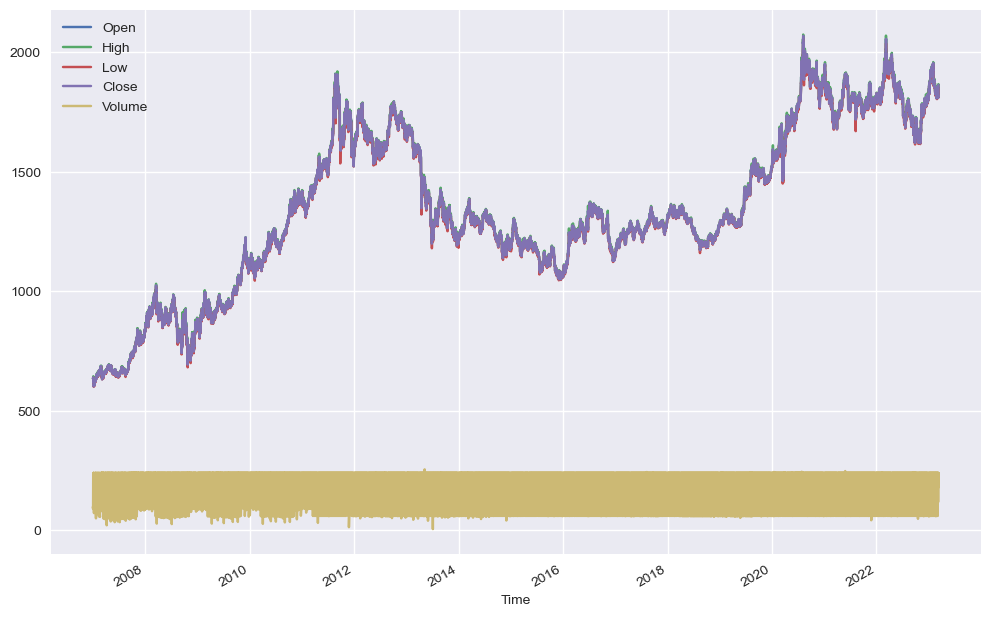

In [9]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [10]:
class Linear_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [11]:
strategy = Linear_Regression
account_size = 10000
folder_ML_Strategy = 'Linear Regression'

In [12]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None
        self.account_size = account_size

    def Prepare(self, lags=0):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["returns_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns_signal'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data

    def Predict(self, lags=0):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=self.account_size, margin=1/100, commission=0.0002)
        result = backtest.run()
        return result

    def Save_Result(self, df, file_path):

        equity_curve = df['_equity_curve'].copy()
        equity_df = pd.DataFrame(equity_curve, columns=['Equity'])
        equity_df['returns'] = equity_df['Equity'].pct_change().fillna(0)
        equity_df = equity_df.drop('Equity', axis=1)
        equity_df.to_csv(file_path, index=True)

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        self.Predict()
        result_test = self.Backtest(self.data_test)
       

        return result_train, result_test

## TF D1

In [13]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'


In [14]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [15]:
train , test = ml.Run()

### In-Sample Backtesting

In [16]:
train

Start                     2007-01-02 00:00:00
End                       2019-12-30 00:00:00
Duration                   4745 days 00:00:00
Exposure Time [%]                   99.950617
Equity Final [$]                  10886.60366
Equity Peak [$]                   11282.25366
Return [%]                           8.866037
Buy & Hold Return [%]              137.008776
Return (Ann.) [%]                    0.529964
Volatility (Ann.) [%]                  1.8023
Sharpe Ratio                         0.294049
Sortino Ratio                         0.40537
Calmar Ratio                         0.069828
Max. Drawdown [%]                    -7.58961
Avg. Drawdown [%]                   -0.342021
Max. Drawdown Duration     3052 days 00:00:00
Avg. Drawdown Duration       65 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     141.443719
Worst Trade [%]                    141.443719
Avg. Trade [%]                    

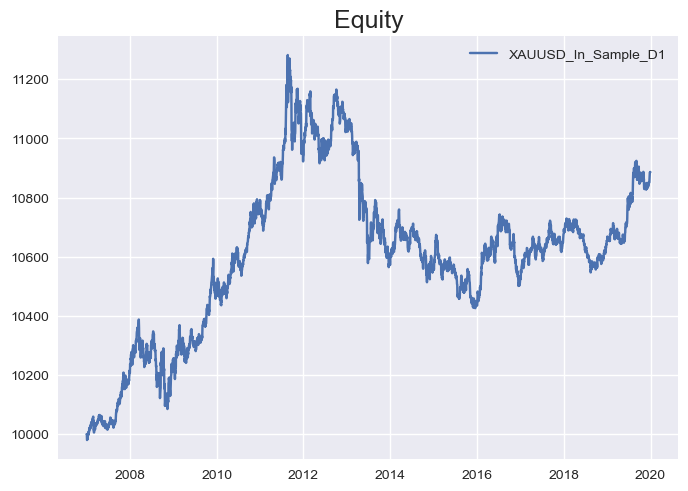

In [17]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [18]:
test

Start                     2020-01-02 00:00:00
End                       2023-03-10 00:00:00
Duration                   1163 days 00:00:00
Exposure Time [%]                    99.79798
Equity Final [$]                 10271.381053
Equity Peak [$]                  10509.131053
Return [%]                           2.713811
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                    0.683909
Volatility (Ann.) [%]                2.598606
Sharpe Ratio                         0.263183
Sortino Ratio                        0.358232
Calmar Ratio                          0.16248
Max. Drawdown [%]                   -4.209197
Avg. Drawdown [%]                   -0.635417
Max. Drawdown Duration      946 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      17.395698
Worst Trade [%]                     17.395698
Avg. Trade [%]                    

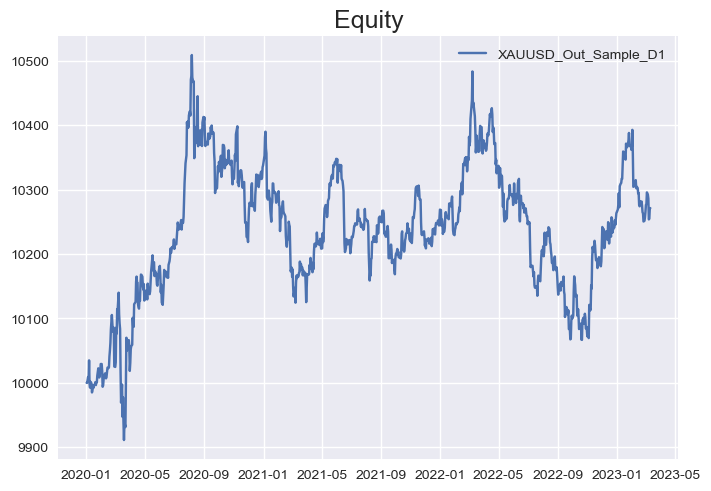

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [20]:
filename_train = f'result_{TF}_In_Sample.csv'

In [21]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [22]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [23]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [24]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'


In [25]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [26]:
train , test = ml.Run()

### In-Sample Backtesting

In [27]:
train

Start                     2007-01-01 04:00:00
End                       2019-12-31 16:00:00
Duration                   4747 days 12:00:00
Exposure Time [%]                   99.990416
Equity Final [$]                 10885.717789
Equity Peak [$]                  11272.897789
Return [%]                           8.857178
Buy & Hold Return [%]              139.055748
Return (Ann.) [%]                    0.529341
Volatility (Ann.) [%]                1.803789
Sharpe Ratio                         0.293461
Sortino Ratio                        0.404526
Calmar Ratio                         0.069499
Max. Drawdown [%]                   -7.616551
Avg. Drawdown [%]                   -0.185946
Max. Drawdown Duration     3052 days 20:00:00
Avg. Drawdown Duration       26 days 19:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     139.224354
Worst Trade [%]                    139.224354
Avg. Trade [%]                    

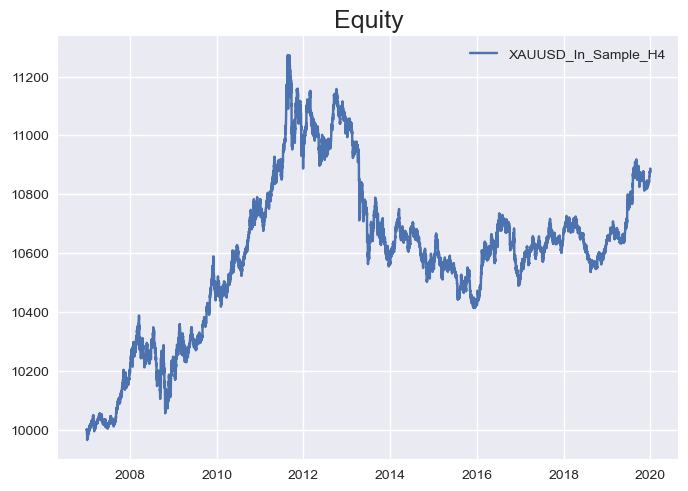

In [28]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [29]:
test

Start                     2020-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.960815
Equity Final [$]                 10343.546173
Equity Peak [$]                  10549.739173
Return [%]                           3.435462
Buy & Hold Return [%]               22.615843
Return (Ann.) [%]                    0.839667
Volatility (Ann.) [%]                2.600542
Sharpe Ratio                         0.322881
Sortino Ratio                        0.441557
Calmar Ratio                         0.197064
Max. Drawdown [%]                   -4.260873
Avg. Drawdown [%]                   -0.305772
Max. Drawdown Duration      945 days 20:00:00
Avg. Drawdown Duration       27 days 11:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      22.610069
Worst Trade [%]                     22.610069
Avg. Trade [%]                    

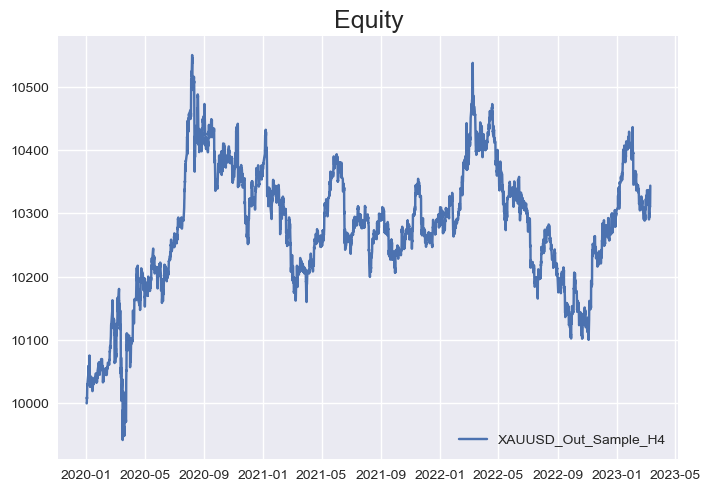

In [30]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [31]:
filename_train = f'result_{TF}_In_Sample.csv'

In [32]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [33]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [34]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [35]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'


In [36]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [37]:
train , test = ml.Run()

### In-Sample Backtesting

In [38]:
train

Start                     2007-01-01 01:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 19:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                  9704.645405
Equity Peak [$]                  11068.174341
Return [%]                          -2.953546
Buy & Hold Return [%]               138.69256
Return (Ann.) [%]                   -0.186149
Volatility (Ann.) [%]                1.855511
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -15.043034
Avg. Drawdown [%]                   -0.163063
Max. Drawdown Duration     3038 days 15:00:00
Avg. Drawdown Duration       17 days 18:00:00
# Trades                                 3305
Win Rate [%]                        55.733737
Best Trade [%]                       5.240521
Worst Trade [%]                    -11.391378
Avg. Trade [%]                    

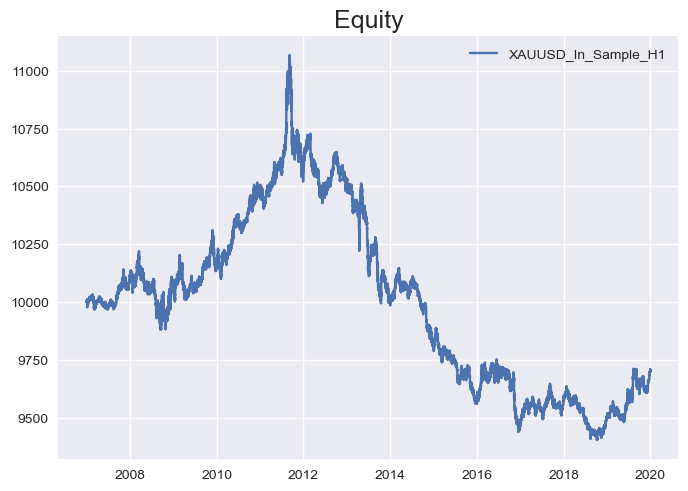

In [39]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [40]:
test

Start                     2020-01-02 00:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 17:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                 10394.463673
Equity Peak [$]                  10624.218083
Return [%]                           3.944637
Buy & Hold Return [%]               22.749066
Return (Ann.) [%]                     0.96633
Volatility (Ann.) [%]                2.605968
Sharpe Ratio                         0.370814
Sortino Ratio                        0.517492
Calmar Ratio                         0.241278
Max. Drawdown [%]                   -4.005058
Avg. Drawdown [%]                    -0.22603
Max. Drawdown Duration      553 days 11:00:00
Avg. Drawdown Duration       12 days 21:00:00
# Trades                                  655
Win Rate [%]                        55.572519
Best Trade [%]                       4.230027
Worst Trade [%]                     -5.988012
Avg. Trade [%]                    

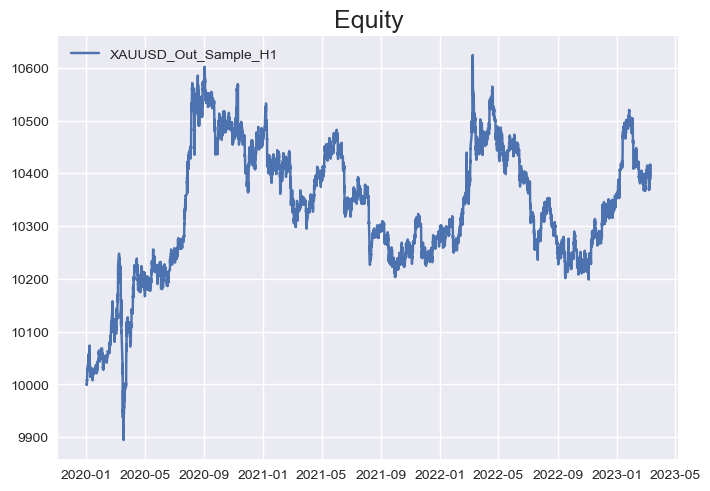

In [41]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [42]:
filename_train = f'result_{TF}_In_Sample.csv'

In [43]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [44]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [45]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [46]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'


In [47]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [48]:
train , test = ml.Run()

### In-Sample Backtesting

In [49]:
train

Start                     2007-01-01 00:30:00
End                       2019-12-31 21:00:00
Duration                   4747 days 20:30:00
Exposure Time [%]                    99.99873
Equity Final [$]                  2950.841511
Equity Peak [$]                  10047.819571
Return [%]                         -70.491585
Buy & Hold Return [%]              138.769304
Return (Ann.) [%]                   -7.309833
Volatility (Ann.) [%]                2.707488
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -70.898066
Avg. Drawdown [%]                   -1.639333
Max. Drawdown Duration     4702 days 04:00:00
Avg. Drawdown Duration      107 days 21:20:00
# Trades                                41453
Win Rate [%]                        54.881432
Best Trade [%]                       3.207378
Worst Trade [%]                     -6.187999
Avg. Trade [%]                    

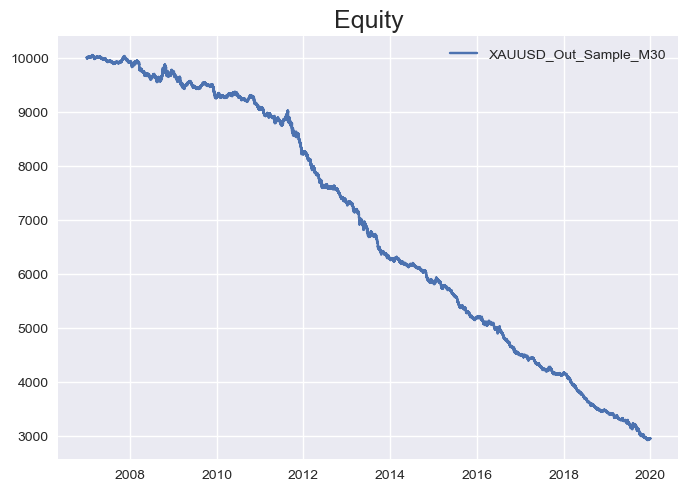

In [50]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [51]:
test

Start                     2020-01-01 23:30:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.994697
Equity Final [$]                  7786.565268
Equity Peak [$]                  10070.430717
Return [%]                         -22.134347
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                   -6.163779
Volatility (Ann.) [%]                2.624629
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.306944
Avg. Drawdown [%]                   -1.324554
Max. Drawdown Duration     1157 days 18:30:00
Avg. Drawdown Duration       64 days 12:17:00
# Trades                                10524
Win Rate [%]                        54.285443
Best Trade [%]                       2.847547
Worst Trade [%]                     -5.182778
Avg. Trade [%]                    

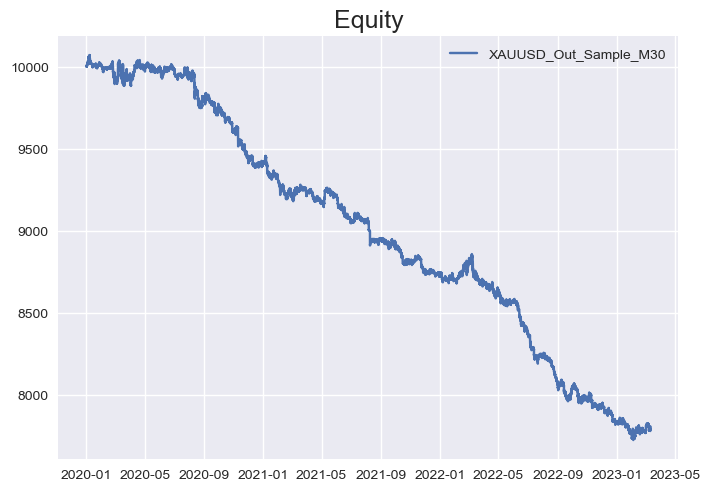

In [52]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [53]:
filename_train = f'result_{TF}_In_Sample.csv'

In [54]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [55]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [56]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [57]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'


In [58]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [59]:
train , test = ml.Run()

### In-Sample Backtesting

In [60]:
train

Start                     2014-09-23 13:15:00
End                       2019-12-31 21:30:00
Duration                   1925 days 08:15:00
Exposure Time [%]                   70.729475
Equity Final [$]                     9.322604
Equity Peak [$]                       10000.0
Return [%]                         -99.906774
Buy & Hold Return [%]               23.687411
Return (Ann.) [%]                  -65.771883
Volatility (Ann.) [%]               11.919464
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.918634
Avg. Drawdown [%]                  -99.918634
Max. Drawdown Duration     1925 days 08:00:00
Avg. Drawdown Duration     1925 days 08:00:00
# Trades                                42071
Win Rate [%]                        47.774001
Best Trade [%]                       1.562534
Worst Trade [%]                     -2.609014
Avg. Trade [%]                    

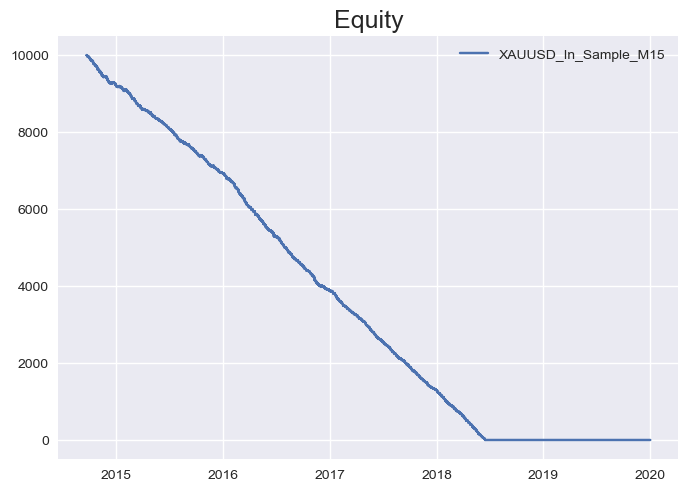

In [61]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [62]:
test

Start                     2020-01-01 23:15:00
End                       2023-03-10 17:45:00
Duration                   1163 days 18:30:00
Exposure Time [%]                    91.71793
Equity Final [$]                      6.59569
Equity Peak [$]                       10000.0
Return [%]                         -99.934043
Buy & Hold Return [%]               22.670469
Return (Ann.) [%]                  -84.469372
Volatility (Ann.) [%]                9.018448
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.954543
Avg. Drawdown [%]                  -99.954543
Max. Drawdown Duration     1163 days 18:15:00
Avg. Drawdown Duration     1163 days 18:15:00
# Trades                                33751
Win Rate [%]                        51.625137
Best Trade [%]                       1.642139
Worst Trade [%]                     -3.492069
Avg. Trade [%]                    

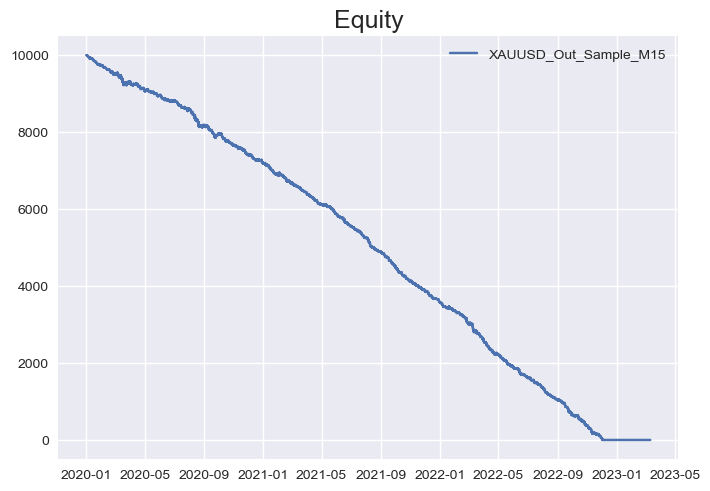

In [63]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [64]:
filename_train = f'result_{TF}_In_Sample.csv'

In [65]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [66]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [67]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [68]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'


In [69]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [70]:
train , test = ml.Run()

### In-Sample Backtesting

In [71]:
train

Start                     2020-05-15 11:15:00
End                       2022-12-30 21:50:00
Duration                    959 days 10:35:00
Exposure Time [%]                   33.635224
Equity Final [$]                    13.955022
Equity Peak [$]                   10000.86308
Return [%]                          -99.86045
Buy & Hold Return [%]                5.233258
Return (Ann.) [%]                  -86.829617
Volatility (Ann.) [%]               10.643861
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.881017
Avg. Drawdown [%]                  -99.881017
Max. Drawdown Duration      959 days 10:25:00
Avg. Drawdown Duration      959 days 10:25:00
# Trades                                32711
Win Rate [%]                        41.781052
Best Trade [%]                       1.108222
Worst Trade [%]                     -1.988915
Avg. Trade [%]                    

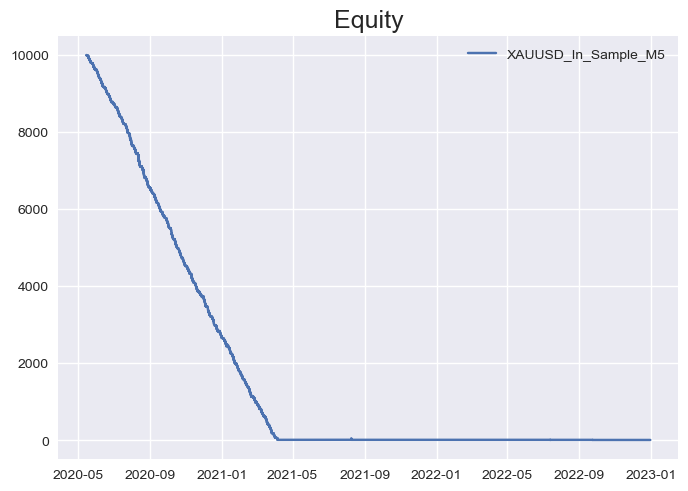

In [72]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [73]:
test

Start                     2023-01-02 23:05:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:50:00
Exposure Time [%]                   99.985069
Equity Final [$]                  7576.741442
Equity Peak [$]                       10000.0
Return [%]                         -24.232586
Buy & Hold Return [%]                1.902369
Return (Ann.) [%]                  -69.371995
Volatility (Ann.) [%]                1.124172
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -24.232586
Avg. Drawdown [%]                  -24.232586
Max. Drawdown Duration       66 days 18:45:00
Avg. Drawdown Duration       66 days 18:45:00
# Trades                                 6920
Win Rate [%]                        37.210983
Best Trade [%]                       0.453433
Worst Trade [%]                     -1.401702
Avg. Trade [%]                    

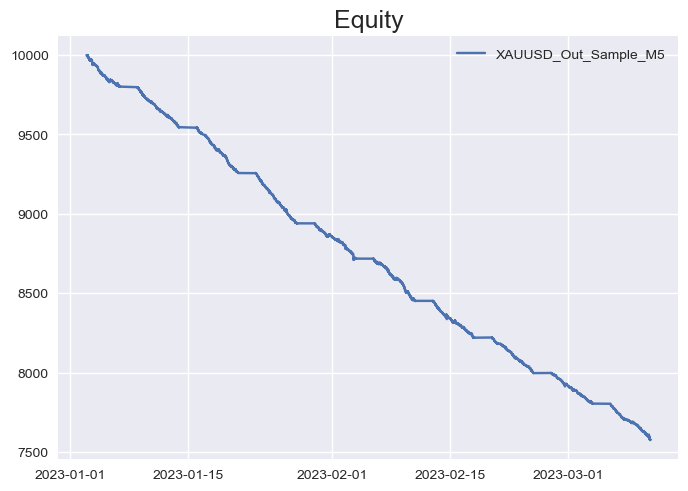

In [74]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [75]:
filename_train = f'result_{TF}_In_Sample.csv'

In [76]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'


In [ ]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')